In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout, Reshape, Conv1D, BatchNormalization, Activation, AveragePooling1D, GlobalAveragePooling1D, Lambda, Input, Concatenate, Add, UpSampling1D, Multiply
from keras.models import Model
from keras.objectives import mean_squared_error
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
from keras.initializers import random_normal
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import Callback
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import KFold, train_test_split

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [47]:
data = pd.read_csv('train.csv',
                    dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
test = pd.read_csv('test.csv',
                    dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})

In [54]:
test

,time,signal
0,500.000092,-2.6498
1,500.000214,-2.8494
2,500.000305,-2.8600
3,500.000397,-2.4350
4,500.000488,-2.6155
...,...,...
1999995,699.999573,-2.9092
1999996,699.999695,-2.7422
1999997,699.999817,-2.8285
1999998,699.999878,-2.9092


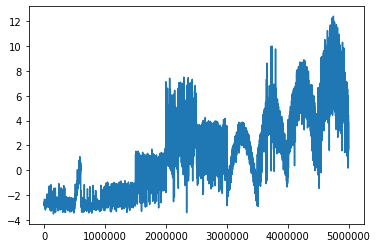

In [6]:
plt.plot(range(0,data_train.shape[0],1000),data_train.signal[0::1000])

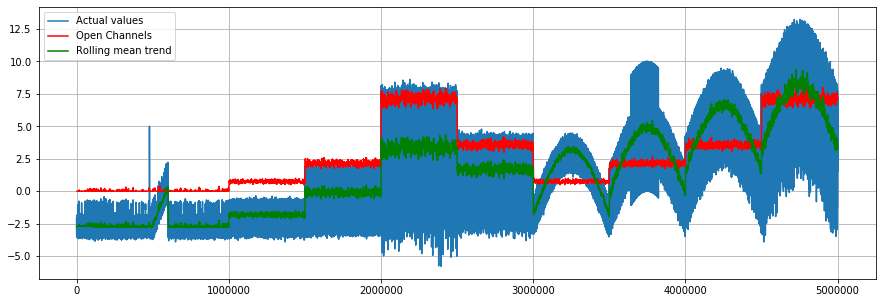

In [72]:
plt.figure(figsize=(15,5))

plt.plot(data['signal'], label='Actual values')
plt.plot(data['open_channels'].rolling(window=2500).mean(), 'r', label='Open Channels')
plt.plot(data['signal'].rolling(window=2500).mean(), 'g', label='Rolling mean trend')
plt.legend(loc='upper left')
plt.grid(True)

In [172]:
y_train.shape

(10, 500000, 11)

In [177]:
train_input = data["signal"].values.reshape(-1,250000,1)
test_input = test["signal"].values.reshape(-1,100000,1)
data_train = (train_input-train_input.mean())/train_input.std()
data_test = (test_input-test_input.mean())/test_input.std()
y_train = pd.get_dummies(data['open_channels']).values.reshape(-1,250000,11)
#y_test = pd.get_dummies(test['open_channels']).values


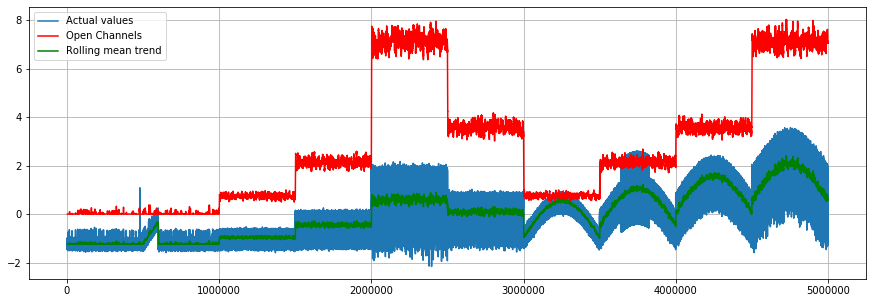

In [98]:
plt.figure(figsize=(15,5))

plt.plot(data_train, label='Actual values')
plt.plot(data['open_channels'].rolling(window=2500).mean(), 'r', label='Open Channels')
plt.plot(data_train.rolling(window=2500).mean(), 'g', label='Rolling mean trend')
plt.legend(loc='upper left')
plt.grid(True)

In [178]:
idx = np.arange(data_train.shape[0])
train_idx, val_idx = train_test_split(idx, random_state = 42,test_size = 0.2)

train_val = data_train[val_idx]
train_train = data_train[train_idx] 
Y_val = y_train[val_idx]
Y_train = y_train[train_idx] 

In [179]:
Y_val.shape

(4, 250000, 11)

In [180]:
def cbr(x, out_layer, kernel, stride, dilation):
    x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def se_block(x_in, layer_n):
    x = GlobalAveragePooling1D()(x_in)
    x = Dense(layer_n//8, activation="relu")(x)
    x = Dense(layer_n, activation="sigmoid")(x)
    x_out=Multiply()([x_in, x])
    return x_out

def resblock(x_in, layer_n, kernel, dilation, use_se=True):
    x = cbr(x_in, layer_n, kernel, 1, dilation)
    x = cbr(x, layer_n, kernel, 1, dilation)
    if use_se:
        x = se_block(x, layer_n)
    x = Add()([x_in, x])
    return x  

def Unet(input_shape=(None,1)):
    layer_n = 64
    kernel_size = 7
    depth = 2

    input_layer = Input(input_shape)    
    input_layer_1 = AveragePooling1D(5)(input_layer)
    input_layer_2 = AveragePooling1D(25)(input_layer)
    
    ########## Encoder
    x = cbr(input_layer, layer_n, kernel_size, 1, 1)#1000
    for i in range(depth):
        x = resblock(x, layer_n, kernel_size, 1)
    out_0 = x

    x = cbr(x, layer_n*2, kernel_size, 5, 1)
    for i in range(depth):
        x = resblock(x, layer_n*2, kernel_size, 1)
    out_1 = x

    x = Concatenate()([x, input_layer_1])    
    x = cbr(x, layer_n*3, kernel_size, 5, 1)
    for i in range(depth):
        x = resblock(x, layer_n*3, kernel_size, 1)
    out_2 = x

    x = Concatenate()([x, input_layer_2])    
    x = cbr(x, layer_n*4, kernel_size, 5, 1)
    for i in range(depth):
        x = resblock(x, layer_n*4, kernel_size, 1)
    
    ########### Decoder
    x = UpSampling1D(5)(x)
    x = Concatenate()([x, out_2])
    x = cbr(x, layer_n*3, kernel_size, 1, 1)

    x = UpSampling1D(5)(x)
    x = Concatenate()([x, out_1])
    x = cbr(x, layer_n*2, kernel_size, 1, 1)

    x = UpSampling1D(5)(x)
    x = Concatenate()([x, out_0])
    x = cbr(x, layer_n, kernel_size, 1, 1)    

    #regressor
    #x = Conv1D(1, kernel_size=kernel_size, strides=1, padding="same")(x)
    #out = Activation("sigmoid")(x)
    #out = Lambda(lambda x: 12*x)(out)
    
    #classifier
    x = Conv1D(11, kernel_size=kernel_size, strides=1, padding="same")(x)
    out = Activation("softmax")(x)
    
    model = Model(input_layer, out)
    
    return model


def augmentations(input_data, target_data):
    #flip
    if np.random.rand()<0.5:    
        input_data = input_data[::-1]
        target_data = target_data[::-1]

    return input_data, target_data


def Datagen(input_dataset, target_dataset, batch_size, is_train=False):
    x=[]
    y=[]
  
    count=0
    idx_1 = np.arange(len(input_dataset))
    #idx_2 = np.arange(len(input_dataset))
    np.random.shuffle(idx_1)
    #np.random.shuffle(idx_2)

    while True:
        for i in range(len(input_dataset)):
            input_data = input_dataset[idx_1[i]]
            target_data = target_dataset[idx_1[i]]
            #input_data_mix = input_dataset[idx_2[i]]
            #target_data_mix = target_dataset[idx_2[i]]

            if is_train:
                input_data, target_data = augmentations(input_data, target_data)
                #input_data_mix, target_data_mix = augmentations(input_data_mix, target_data_mix)
                
            x.append(input_data)
            y.append(target_data)
            count+=1
            if count==batch_size:
                x=np.array(x, dtype=np.float32)
                y=np.array(y, dtype=np.float32)
                inputs = x
                targets = y       
                x = []
                y = []
                count=0
                yield inputs, targets

class macroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)

    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis=2).reshape(-1)
        f1_val = f1_score(self.targets, pred, average="macro")
        print("val_f1_macro_score: ", f1_val)
                
def model_fit(model, train_inputs, train_targets, val_inputs, val_targets, n_epoch, batch_size=32):
    hist = model.fit_generator(
        Datagen(train_inputs, train_targets, batch_size, is_train=True),
        steps_per_epoch = len(train_inputs) // batch_size,
        epochs = n_epoch,
        validation_data=Datagen(val_inputs, val_targets, batch_size),
        validation_steps = len(val_inputs) // batch_size,
        callbacks = [lr_schedule, macroF1(model, val_inputs, val_targets)],
        shuffle = False,
        verbose = 1
        )
    return hist

def lrs(epoch):
    if epoch<25:
        lr = learning_rate
    elif epoch<35:
        lr = learning_rate/10
    else:
        lr = learning_rate/100
    return lr

In [181]:
K.clear_session()
model = Unet()

learning_rate = 0.0005
n_epoch = 40
batch_size = 1

lr_schedule = LearningRateScheduler(lrs)

model.compile(loss=categorical_crossentropy, 
              optimizer=Adam(learning_rate=lr), 
              metrics=["accuracy"])


In [146]:
Y_train.shape

(800, 5000, 1)

In [182]:
model_fit(model, train_train, Y_train, train_val, Y_val, n_epoch, batch_size)

Epoch 1/40
16/16 [==============================] - 546s 34s/step - loss: 2.4933 - accuracy: 0.1000 - val_loss: 0.2977 - val_accuracy: 0.5423
val_f1_macro_score:  0.12069212708702842
Epoch 2/40
16/16 [==============================] - 542s 34s/step - loss: 2.1106 - accuracy: 0.2571 - val_loss: 2.2717 - val_accuracy: 0.0554
val_f1_macro_score:  0.0542452524437123
Epoch 3/40
16/16 [==============================] - 549s 34s/step - loss: 1.9872 - accuracy: 0.3137 - val_loss: 2.1502 - val_accuracy: 0.0619
val_f1_macro_score:  0.04058203926263744
Epoch 4/40
16/16 [==============================] - 525s 33s/step - loss: 1.9247 - accuracy: 0.3175 - val_loss: 2.1086 - val_accuracy: 0.0699
val_f1_macro_score:  0.028391372074600615
Epoch 5/40
16/16 [==============================] - 525s 33s/step - loss: 1.8814 - accuracy: 0.3433 - val_loss: 2.2456 - val_accuracy: 0.0654
val_f1_macro_score:  0.020772130445325245
Epoch 6/40
16/16 [==============================] - 574s 36s/step - loss: 1.8709 - a

KeyboardInterrupt: 